<a href="https://colab.research.google.com/github/meraj687/ProgrammingWithPython_assignment_IU/blob/main/ProgrammingWithPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TASK 1

In [2]:
#Task01
# ---------------------
# Imports
# ---------------------
import pandas as pd
import matplotlib.pyplot as plt
import unittest
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Enable Bokeh inline output in Colab
output_notebook()

# ---------------------
# DataHandler class
# ---------------------
class DataHandler:
    """
    A class for handling the loading, processing, and validation of training, ideal, and test datasets.

    Attributes:
        ideal_df (DataFrame): DataFrame containing the ideal function data.
        train_df (DataFrame): DataFrame containing the training data.
    """

    def __init__(self, ideal_file, train_file):
        """
        Initializing the DataHandler by loading CSV files into DataFrames.

        Args:
            ideal_file (str): Path to the ideal dataset CSV file.
            train_file (str): Path to the training dataset CSV file.

        Raises:
            FileNotFoundError: If the file is not found.
            pd.errors.EmptyDataError: If the file is empty or corrupt.
            Exception: For any other error during file reading.
        """
        try:
            self.ideal_df = pd.read_csv(ideal_file)
            self.train_df = pd.read_csv(train_file)
        except FileNotFoundError as e:
            print(f"Error: One of the input files was not found. Details: {e}")
            raise
        except pd.errors.EmptyDataError as e:
            print(f"Error: One of the input files is empty or corrupt. Details: {e}")
            raise
        except Exception as e:
            print(f"An unexpected error occurred while reading files: {e}")
            raise

    def get_best_fit_functions(self):
        """
        Determines the ideal functions that best fit each training column
        using the Least Squares deviation method.

        Returns:
            dict: Mapping from training column names to best-fit ideal column names.

        Raises:
            KeyError: If expected columns are missing.
            Exception: For any unexpected errors during computation.
        """
        best_fit = {}
        try:
            for col in self.train_df.columns[1:]:
                deviations = {
                    ideal_col: ((self.train_df[col] - self.ideal_df[ideal_col])**2).sum()
                    for ideal_col in self.ideal_df.columns[1:]
                }
                best_fit[col] = min(deviations, key=deviations.get)
            print("Best fit functions:", best_fit)
        except KeyError as e:
            print(f"Missing expected columns in the data: {e}")
            raise
        except Exception as e:
            print(f"Error while computing best fit functions: {e}")
            raise
        return best_fit

    def validate_test_data(self, test_file, best_fit):
        """
        Validates test data by checking if each point fits one of the ideal functions within a
        deviation of sqrt(2) * max deviation from training data.

        Args:
            test_file (str): Path to the test dataset.
            best_fit (dict): Dictionary mapping train columns to ideal function columns.

        Returns:
            list: A list of tuples containing valid test data points and their corresponding ideal function.

        Raises:
            Exception: For any errors during test data reading or validation.
        """
        try:
            test_df = pd.read_csv(test_file)
        except FileNotFoundError as e:
            print(f"Test file not found: {e}")
            raise
        except pd.errors.EmptyDataError as e:
            print(f"Test file is empty or unreadable: {e}")
            raise
        except Exception as e:
            print(f"Unexpected error reading test file: {e}")
            raise

        results = []
        try:
            for _, row in test_df.iterrows():
                x_val = row["x"]
                y_val = row["y"]
                if x_val not in self.ideal_df["x"].values:
                    continue
                for train_col, ideal_col in best_fit.items():
                    max_dev = abs(self.train_df[train_col] - self.ideal_df[ideal_col]).max()
                    ideal_y_values = self.ideal_df.loc[self.ideal_df["x"] == x_val, ideal_col]
                    if not ideal_y_values.empty:
                        ideal_y = ideal_y_values.values[0]
                        deviation = abs(y_val - ideal_y)
                        if deviation <= max_dev * (2**0.5):
                            results.append((x_val, y_val, ideal_col, deviation))
            print("Validated test data (first 10 results):", results[:10])
        except Exception as e:
            print(f"Error during test data validation: {e}")
            raise
        return results

# ---------------------
# Visualization Functions
# ---------------------
def plot_data(df, title):
    """
    Plots the given DataFrame using Bokeh.

    Args:
        df (DataFrame): The DataFrame containing 'x' and y-columns to plot.
        title (str): Title of the plot.
    """
    p = figure(title=title, x_axis_label='x', y_axis_label='y', width=700, height=400)
    for col in df.columns[1:5]:  # Only plot first 4 columns to avoid clutter
        p.line(df['x'], df[col], legend_label=col, line_width=2)
    show(p)

def plot_best_fit(best_fit, train_df, ideal_df):
    """
    Plots training data and its best-fit ideal functions using Bokeh.

    Args:
        best_fit (dict): Mapping from training to ideal function columns.
        train_df (DataFrame): The training dataset.
        ideal_df (DataFrame): The ideal dataset.
    """
    p = figure(title="Best Fit Functions", x_axis_label='x', y_axis_label='y', width=700, height=400)
    for train_col, ideal_col in best_fit.items():
        p.scatter(train_df['x'], train_df[train_col], legend_label=f"Train: {train_col}", color="blue", size=6)
        p.line(ideal_df['x'], ideal_df[ideal_col], legend_label=f"Ideal: {ideal_col}", line_width=2, color="red")
    show(p)

# ---------------------
# Unit Testing Class
# ---------------------
class TestDatasetIntegrity(unittest.TestCase):
    """
    Unit tests for validating integrity of datasets.
    """
    def test_no_missing_values(self):
        """Test if there are any missing (NaN) values in the datasets."""
        self.assertFalse(data_handler.ideal_df.isnull().values.any(), "ideal.csv contains missing values")
        self.assertFalse(data_handler.train_df.isnull().values.any(), "train.csv contains missing values")

    def test_correct_data_types(self):
        """Test if all values are numeric (int or float)."""
        self.assertTrue(data_handler.ideal_df.dtypes.apply(lambda x: x.kind in 'if').all(), "ideal.csv has non-numeric values")
        self.assertTrue(data_handler.train_df.dtypes.apply(lambda x: x.kind in 'if').all(), "train.csv has non-numeric values")

    def test_x_value_ranges(self):
        """Test whether x values fall within the expected range [-20, 20]."""
        self.assertGreaterEqual(data_handler.ideal_df["x"].min(), -20, "ideal.csv x values out of expected range")
        self.assertLessEqual(data_handler.ideal_df["x"].max(), 20, "ideal.csv x values out of expected range")
        self.assertGreaterEqual(data_handler.train_df["x"].min(), -20, "train.csv x values out of expected range")
        self.assertLessEqual(data_handler.train_df["x"].max(), 20, "train.csv x values out of expected range")

# ---------------------
# Main Execution Block
# ---------------------
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # File paths (change if uploading manually)
    ideal_path = "/content/drive/MyDrive/Aryaan_project_AI_MSc/Programming_with_Python_Assignment/ideal.csv"
    train_path = "/content/drive/MyDrive/Aryaan_project_AI_MSc/Programming_with_Python_Assignment/train.csv"
    test_path = "/content/drive/MyDrive/Aryaan_project_AI_MSc/Programming_with_Python_Assignment/test.csv"

    # Load and process data
    data_handler = DataHandler(ideal_path, train_path)
    best_fit = data_handler.get_best_fit_functions()

    # Visualizations
    plot_data(data_handler.ideal_df, "Ideal Functions")
    plot_data(data_handler.train_df, "Training Data")
    plot_best_fit(best_fit, data_handler.train_df, data_handler.ideal_df)

    # Validate test data
    validated_results = data_handler.validate_test_data(test_path, best_fit)

    # Run unit tests
    unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestDatasetIntegrity))

except Exception as e:
    print(f"Fatal error during execution: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best fit functions: {'y1': 'y42', 'y2': 'y41', 'y3': 'y11', 'y4': 'y48'}


...
----------------------------------------------------------------------
Ran 3 tests in 0.007s

OK


Validated test data (first 10 results): [(np.float64(17.5), np.float64(34.16104), 'y41', np.float64(0.351148000000002)), (np.float64(0.3), np.float64(1.2151024), 'y41', np.float64(0.4673422999999999)), (np.float64(0.8), np.float64(1.4264555), 'y41', np.float64(0.5322224999999998)), (np.float64(0.8), np.float64(1.4264555), 'y11', np.float64(0.6264555)), (np.float64(14.0), np.float64(-0.06650608), 'y48', np.float64(0.13423253)), (np.float64(-15.0), np.float64(-0.20536347), 'y48', np.float64(0.45237137)), (np.float64(5.8), np.float64(10.711373), 'y41', np.float64(0.656326)), (np.float64(-19.8), np.float64(-19.915014), 'y11', np.float64(0.11501399999999862)), (np.float64(18.9), np.float64(19.193245), 'y11', np.float64(0.2932450000000024)), (np.float64(8.8), np.float64(-0.7260513), 'y48', np.float64(0.48884017999999996))]


TASK 2
Analysis and Visualization of Nanofluid Heat Transfer Dataset


.
----------------------------------------------------------------------
Ran 4 tests in 1.162s

OK


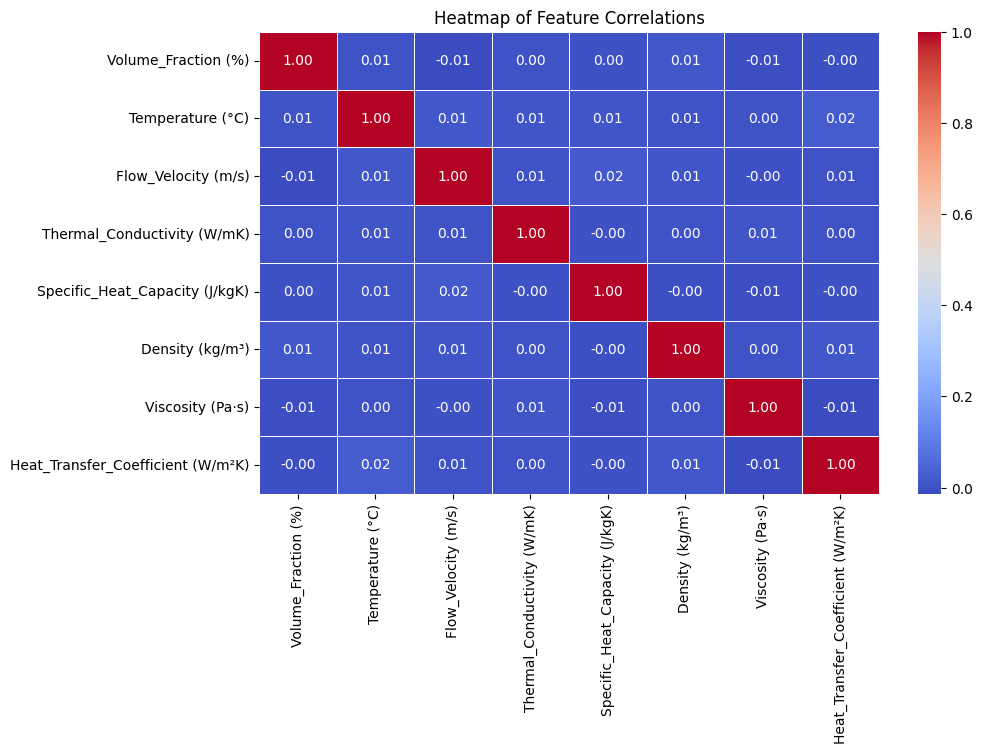

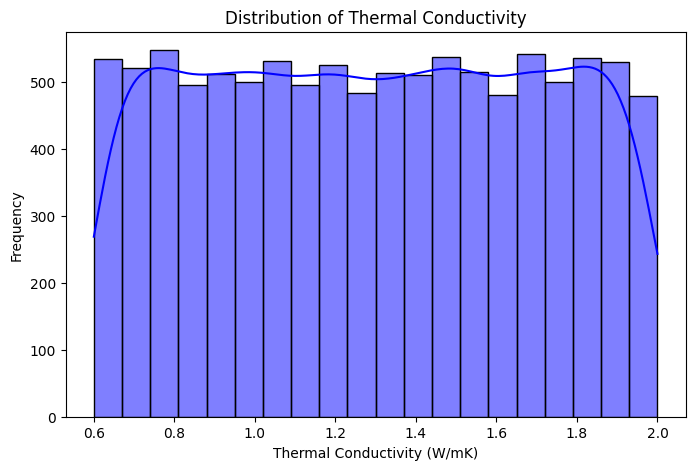

<ipython-input-1-260a566f01b8>:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Nanoparticle_Type", y="Heat_Transfer_Coefficient (W/m²K)", data=data, palette="viridis")


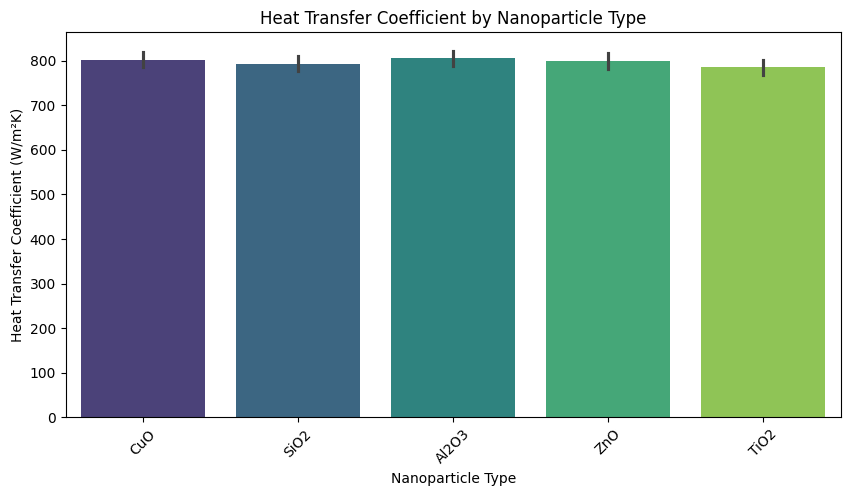

<ipython-input-1-260a566f01b8>:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Nanoparticle_Type", y="Viscosity (Pa·s)", data=data, palette="coolwarm")


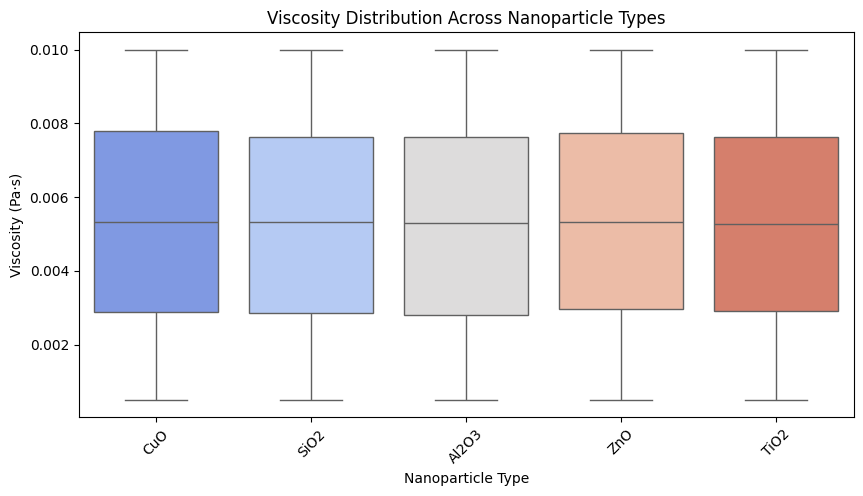

✅ All visualizations generated successfully!


In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import unittest
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource
import plotly.graph_objects as go

# ================================
# **1️⃣ Load Dataset Function**
# ================================
def load_data(file_path):
    """
    Load the dataset from the specified CSV file path.

    Parameters:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded data as a pandas DataFrame.
    """
    return pd.read_csv(file_path)


# ================================
# **2️⃣ Preprocessing Function**
# ================================
def preprocess_data(data):
    """
    Preprocess the dataset to retain only numeric columns.

    Parameters:
        data (pd.DataFrame): Raw input dataset.

    Returns:
        pd.DataFrame: DataFrame containing only numeric columns.
    """
    return data.select_dtypes(include=['number'])


# ================================
# **3️⃣ Unit Testing Class**
# ================================
class TestNanofluidDataset(unittest.TestCase):
    """
    Unit test class for validating the nanofluid heat transfer dataset.
    Includes tests for loading, structure, missing values, and plotting.
    """

    def setUp(self):
        """
        Set up method to load and preprocess dataset before each test.
        """
        self.file_path = r"/content/drive/MyDrive/Aryaan_project_AI_MSc/Programming_with_Python_Assignment/nanofluid_heat_transfer_dataset.csv"
        self.data = load_data(self.file_path)
        self.numeric_data = preprocess_data(self.data)

    def test_data_loading(self):
        """
        Test whether the dataset is loaded correctly and not empty.
        """
        self.assertFalse(self.data.empty, "Dataset is empty!")

    def test_numeric_columns(self):
        """
        Test whether numeric columns are present in the dataset.
        """
        self.assertGreater(len(self.numeric_data.columns), 0, "No numeric columns found!")

    def test_missing_values(self):
        """
        Test that the dataset has no missing values.
        """
        missing_count = self.data.isnull().sum().sum()
        self.assertEqual(missing_count, 0, f"Dataset contains {missing_count} missing values!")

    def test_scatter_plot(self):
        """
        Test generation of a Bokeh scatter plot for flow velocity vs heat transfer coefficient.
        """
        try:
            scatter = figure(title="Flow Velocity vs Heat Transfer Coefficient",
                             x_axis_label="Flow Velocity (m/s)",
                             y_axis_label="Heat Transfer Coefficient (W/m²K)",
                             width=800, height=500)
            source = ColumnDataSource(self.data)
            scatter.circle(x="Flow_Velocity (m/s)", y="Heat_Transfer_Coefficient (W/m²K)",
                           source=source, size=8, color="navy", alpha=0.6)
            self.assertTrue(True)
        except Exception as e:
            self.fail(f"Scatter plot generation failed! Error: {e}")


# ================================
# **4️⃣ HEATMAP - Feature Correlation**
# ================================
def plot_heatmap(numeric_data):
    """
    Plot a heatmap to visualize correlations between numeric features.

    Parameters:
        numeric_data (pd.DataFrame): DataFrame containing only numeric features.
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Heatmap of Feature Correlations")
    plt.show()


# ================================
# **5️⃣ SCATTER PLOT (Bokeh)**
# ================================
def plot_scatter_bokeh(data):
    """
    Plot a scatter plot using Bokeh to visualize the relationship between
    flow velocity and heat transfer coefficient.

    Parameters:
        data (pd.DataFrame): Full dataset.
    """
    output_file("scatter_plot.html")
    scatter = figure(title="Flow Velocity vs Heat Transfer Coefficient",
                     x_axis_label="Flow Velocity (m/s)",
                     y_axis_label="Heat Transfer Coefficient (W/m²K)",
                     width=800, height=500)
    source = ColumnDataSource(data)
    scatter.circle(x="Flow_Velocity (m/s)", y="Heat_Transfer_Coefficient (W/m²K)",
                   source=source, size=8, color="navy", alpha=0.6)
    show(scatter)


# ================================
# **6️⃣ HISTOGRAM - Thermal Conductivity**
# ================================
def plot_histogram(data):
    """
    Plot a histogram showing the distribution of thermal conductivity.

    Parameters:
        data (pd.DataFrame): Full dataset.
    """
    plt.figure(figsize=(8, 5))
    sns.histplot(data["Thermal_Conductivity (W/mK)"], bins=20, kde=True, color="blue")
    plt.xlabel("Thermal Conductivity (W/mK)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Thermal Conductivity")
    plt.show()


# ================================
# **7️⃣ BAR PLOT - Heat Transfer Coefficient by Nanoparticle Type**
# ================================
def plot_bar(data):
    """
    Plot a bar chart to compare heat transfer coefficient across nanoparticle types.

    Parameters:
        data (pd.DataFrame): Full dataset.
    """
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Nanoparticle_Type", y="Heat_Transfer_Coefficient (W/m²K)", data=data, palette="viridis")
    plt.xticks(rotation=45)
    plt.xlabel("Nanoparticle Type")
    plt.ylabel("Heat Transfer Coefficient (W/m²K)")
    plt.title("Heat Transfer Coefficient by Nanoparticle Type")
    plt.show()


# ================================
# **8️⃣ BOXPLOT - Viscosity Across Nanoparticle Types**
# ================================
def plot_boxplot(data):
    """
    Plot a box plot to visualize viscosity distribution across nanoparticle types.

    Parameters:
        data (pd.DataFrame): Full dataset.
    """
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="Nanoparticle_Type", y="Viscosity (Pa·s)", data=data, palette="coolwarm")
    plt.xticks(rotation=45)
    plt.xlabel("Nanoparticle Type")
    plt.ylabel("Viscosity (Pa·s)")
    plt.title("Viscosity Distribution Across Nanoparticle Types")
    plt.show()


# ================================
# **9️⃣ 3D SCATTER PLOT - Plotly**
# ================================
def plot_3d_scatter_plot(data, x_feature, y_feature, z_feature):
    """
    Plot an interactive 3D scatter plot using Plotly.

    Parameters:
        data (pd.DataFrame): Full dataset.
        x_feature (str): Column name for X-axis.
        y_feature (str): Column name for Y-axis.
        z_feature (str): Column name for Z-axis.
    """
    fig = go.Figure(data=[go.Scatter3d(
        x=data[x_feature],
        y=data[y_feature],
        z=data[z_feature],
        mode='markers',
        marker=dict(
            size=5,
            color=data[z_feature],
            colorscale='Viridis',
            opacity=0.8
        )
    )])

    fig.update_layout(
        title=f'3D Scatter Plot: {x_feature} vs {y_feature} vs {z_feature}',
        scene=dict(
            xaxis_title=x_feature,
            yaxis_title=y_feature,
            zaxis_title=z_feature
        ),
        width=800,
        height=600
    )

    fig.show()


# ================================
# **🔟 MAIN FUNCTION**
# ================================
def main(file_path):
    """
    Main function to load dataset, run unit tests, and generate visualizations.

    Parameters:
        file_path (str): Path to the nanofluid heat transfer dataset.
    """
    # Load and preprocess the data
    data = load_data(file_path)
    numeric_data = preprocess_data(data)

    # Run unit tests
    unittest.main(argv=[''], exit=False)

    # Generate all visualizations
    plot_heatmap(numeric_data)
    plot_scatter_bokeh(data)
    plot_histogram(data)
    plot_bar(data)
    plot_boxplot(data)
    plot_3d_scatter_plot(data, 'Flow_Velocity (m/s)', 'Heat_Transfer_Coefficient (W/m²K)', 'Viscosity (Pa·s)')

    print("✅ All visualizations generated successfully!")


# ================================
# **📌 Entry Point**
# ================================
if __name__ == '__main__':
    file_path = r"/content/drive/MyDrive/Aryaan_project_AI_MSc/Programming_with_Python_Assignment/nanofluid_heat_transfer_dataset.csv"
    main(file_path)
